# Population distributions by strata 

Estimate population distributions by strata in Census (2018), and HTS (2019)

In [132]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import orca
import matplotlib.pyplot as plt
import geopandas as gpd

## Household travel survey 

The objective of this section is obtain mode BRT users distrution be strata and walking access distance to a BRT statio to home location.

In [151]:
# Files 
path_to_files = '../data/input/hts2019/data_base/csv_files/'
legs_path = 'EtapasEODH2019.csv'
trips_path = 'ViajesEODH2019.csv'
persons_path = 'PersonasEODH2019.csv'
household_path = 'HogaresEODH2019.csv'
vehicle_path = 'Veh°culosEODH2019.csv'

households = pd.read_csv(path_to_files + household_path ,sep=',', index_col = 'Id_Hogar')
persons = pd.read_csv(path_to_files + persons_path ,sep=',')
trips = pd.read_csv(path_to_files + trips_path ,sep=';')
legs = pd.read_csv(path_to_files + legs_path ,sep=';')

In [152]:
# formating 
persons.id_hogar = persons.id_hogar.astype(str)
persons.id_persona = persons.id_persona.astype(str)
persons['id_person'] = persons.id_hogar + persons.id_persona
persons.set_index('id_person', inplace = True)

trips.id_hogar = trips.id_hogar.astype(str)
trips.id_persona = trips.id_persona.astype(str)
trips.id_viaje = trips.id_viaje.astype(str)
trips['id_person'] = trips.id_hogar + trips.id_persona
trips['id_trip'] = trips.id_hogar + trips.id_persona +  trips.id_viaje
trips.set_index('id_trip', inplace = True)

legs.id_hogar = legs.id_hogar.astype(str)
legs.id_persona = legs.id_persona.astype(str)
legs.id_viaje = legs.id_viaje.astype(str)
legs.id_etapa = legs.id_etapa.astype(str)
legs['id_person'] = legs.id_hogar + legs.id_persona
legs['id_trip'] = legs.id_hogar + legs.id_persona +  legs.id_viaje
legs['id_leg'] = legs.id_hogar + legs.id_persona +  legs.id_viaje + legs.id_etapa
legs.set_index('id_leg', inplace = True)

In [153]:
#Generate ORCA tables 
orca.add_table('households', households)
orca.add_table('persons', persons)
orca.add_table('trips', trips)
orca.add_table('legs', legs);

# pre-merge orca
orca.broadcast(cast = 'households', onto = 'persons', cast_index = True, onto_on = 'id_hogar')
orca.broadcast(cast = 'persons', onto = 'trips', cast_index = True, onto_on = 'id_person')
orca.broadcast(cast = 'trips', onto = 'legs', cast_index = True, onto_on = 'id_trip')

# Actual Merge 
trips_merge = orca.merge_tables(target = 'trips', tables = ['persons', 'households', 'trips'])

In [154]:
# BRT mode
trips_transmi = trips_merge[trips_merge.modo_principal == 'TransMilenio']

### BRT users by strata distribution

In [142]:
trips_transmi['p5_estrato'] = trips_transmi['p5_estrato'].fillna(0).astype(int)
trips_transmi = trips_transmi[trips_transmi.p5_estrato != 0] #Drop nan or estrata 0 

In [143]:
# Count users by strata 
strata_counts = trips_transmi.drop_duplicates(subset = 'id_person')['p5_estrato'].value_counts()

In [144]:
#Caluclate probability distribution
brt_by_strata = strata_counts/strata_counts.sum()
brt_by_strata

3    0.363586
2    0.347265
4    0.131231
1    0.120313
5    0.027239
6    0.010366
Name: p5_estrato, dtype: float64

### Access and egress walking time distribution

- p28_lugar_destino == 1 (home BRT station - egress time) 
- p28_lugar_origen == 1 (home BRT station home - access time)

In [145]:
#Access and egress time
mask_1 = trips_transmi.p28_lugar_destino == 1
mask_2 = trips_transmi.lugar_origen == 1
home_trips = trips_transmi[(mask_1)|(mask_2)]

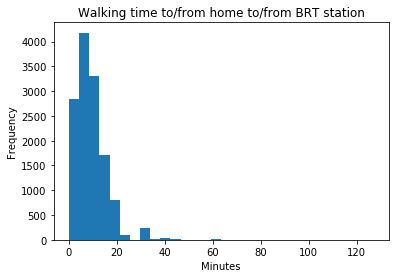

In [146]:
home_trips[['lugar_origen', 'p28_lugar_destino', 'p30_camino_minutos']].p30_camino_minutos.plot.hist(bins = 30)
plt.xlabel('Minutes')
plt.title('Walking time to/from home to/from BRT station');

In [112]:
minutes = 20
less_minutes = (home_trips[['lugar_origen', 'p28_lugar_destino', 'p30_camino_minutos']].p30_camino_minutos < minutes).sum()
pct = less_minutes/len(home_trips)
print (pct)

0.9103027564392228


90% of the respondents have a walking access/egress time of less than 20 minutes

## CENSUS, 2018 

Estimates the population strata distribution. CENSUS (2018)

In [114]:
path_to_files = '../data/input/'
pop = gpd.read_file(path_to_files + 'blocks_pop_2018/blocks_pop_2018.shp')

In [131]:
pop1 = pop[['ESTRATO', 'TOTAL_PERS']]
pop1['TOTAL_PERS'] = pop['TOTAL_PERS'].fillna(0).astype(int)

strata_counts_census = pop1[['ESTRATO', 'TOTAL_PERS']].groupby('ESTRATO')['TOTAL_PERS'].sum()

#Caluclate probability distribution
pop_by_strata = strata_counts_census/strata_counts_census.sum()
pop_by_strata

ESTRATO
1    0.090261
2    0.418021
3    0.340074
4    0.098446
5    0.031054
6    0.022144
Name: TOTAL_PERS, dtype: float64